In [1]:
import cv2
import os
from PIL import Image
import numpy as np
#import Augmentor
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input  
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions


from tensorflow.keras.models import Model

2024-04-24 16:35:39.666308: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 16:35:39.666416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 16:35:39.777177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_path = os.path.join('/kaggle/input/ultrasound/data')
dir_path = os.listdir(base_path)
print(dir_path)
files = []
labels = []

['benign', 'normal', 'malignant']


In [3]:
def img_preprocessing(img_path):
    img = load_img(img_path, target_size=(224, 224)) 
    img = img_to_array(img)  # Convert to NumPy array
    #img = np.expand_dims(img, axis=0)# Add a batch dimension (needed for the model)
    img = preprocess_input(img)  
    return img

In [5]:
for i, img_class in enumerate(dir_path):
    for image in os.listdir(os.path.join(base_path,img_class)):
        img_path = os.path.join(base_path,img_class,image)
        img_array = img_preprocessing(img_path)
        files.append(img_array)
        labels.append(i)

In [6]:
indices = np.arange(len(files))
np.random.shuffle(indices)
m_files = []
m_labels = []
for indice in indices:
    m_files.append(files[indice])
    m_labels.append(labels[indice])

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [8]:
x_train, x_test, y_train, y_test = train_test_split(m_files, m_labels, test_size = 0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [9]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [10]:
y_train_encoded = to_categorical(y_train, num_classes=3)
print(f'1: {y_train_encoded}')
y_train_encoded = y_train_encoded.reshape(-1, 3) 
print(f'2: {y_train_encoded}')

y_val_encoded = to_categorical(y_val, num_classes=3)
y_val_encoded = y_val_encoded.reshape(-1, 3)


#x_test = to_categorical(y_train, num_classes=3)
#y_test = to_categorical(y_train, num_classes=3)

1: [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
2: [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization,Activation
from tensorflow.keras.initializers import GlorotUniform, HeNormal
import matplotlib.pyplot as plt
from keras import regularizers
from keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.regularizers import l2

In [21]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3) )
base_model.trainable = False

In [14]:
#base_model.summary()

In [15]:
base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
    if layer.name in ['conv5_block15_2_conv','conv5_block15_1_conv','conv5_block16_2_conv','conv5_block16_1_conv']:
        layer.trainable = True
    else:
        layer.trainable = False
                

In [33]:
model = Sequential()

model.add(base_model) 

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(32,kernel_regularizer=tf.keras.regularizers.l2(0.5)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_f = model.fit(x_train, y_train_encoded ,validation_data=(x_val,y_val_encoded), epochs=70, batch_size=70) 

Epoch 1/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4408 - loss: 31.8815 - val_accuracy: 0.5688 - val_loss: 26.9385
Epoch 2/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.7405 - loss: 25.1557 - val_accuracy: 0.6514 - val_loss: 21.5586
Epoch 3/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.8101 - loss: 19.9172 - val_accuracy: 0.6972 - val_loss: 17.1167
Epoch 4/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.8788 - loss: 15.7082 - val_accuracy: 0.6835 - val_loss: 13.5786
Epoch 5/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8831 - loss: 12.4583 - val_accuracy: 0.7477 - val_loss: 10.8040
Epoch 6/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9160 - loss: 9.8781 - val_accuracy: 0.7661 - val_loss: 8.6157
Epoch 7/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9282 - loss: 7.8599 - val_accuracy: 0.7752 - val_loss: 6.9257
Epoch 8/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9443 - loss: 6.2844 - val_accu


KeyboardInterrupt



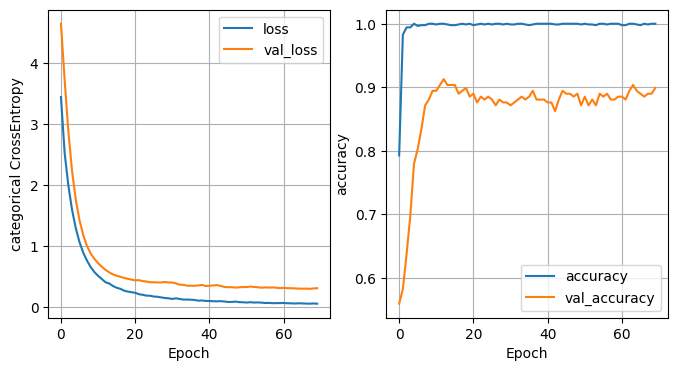

In [19]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('categorical CrossEntropy')
    ax1.legend() 
    ax1.grid(True)
    
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

plot_history(history_f)
#plot_history(history_m)

In [23]:
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        89
           1       0.90      0.91      0.90        88
           2       0.95      0.82      0.88        95

    accuracy                           0.88       272
   macro avg       0.88      0.88      0.88       272
weighted avg       0.89      0.88      0.88       272



In [1]:
base_model = DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3) )
base_model.load_weights(r'/kaggle/input/chexnet-keras-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')
#base_model.trainable = True

NameError: name 'DenseNet121' is not defined

In [25]:
#base_model.summary()

In [44]:
base_model.trainable = True

#set_trainable = False

for layer in base_model.layers:
    if layer.name in ['conv5_block15_2_conv','conv5_block15_1_conv','conv5_block16_2_conv','conv5_block16_1_conv'] :
        layer.trainable = True
    else:
        layer.trainable = False

In [39]:
from tensorflow.keras.optimizers import Adam

In [45]:
#base_model.trainable = True
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#x = Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.05))(x)
x = BatchNormalization()(x)
#x = Activation('relu')(x)
x = Dropout(0.4)(x)

predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train_encoded ,validation_data=(x_val,y_val_encoded), epochs=120, batch_size=64)

Epoch 1/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.3592 - loss: 1.5398 - val_accuracy: 0.4952 - val_loss: 0.9845
Epoch 2/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.4755 - loss: 1.1455 - val_accuracy: 0.5571 - val_loss: 0.9147
Epoch 3/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5738 - loss: 1.0026 - val_accuracy: 0.6095 - val_loss: 0.8554
Epoch 4/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.6397 - loss: 0.8693 - val_accuracy: 0.6381 - val_loss: 0.7730
Epoch 5/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.6419 - loss: 0.7927 - val_accuracy: 0.6667 - val_loss: 0.7317
Epoch 6/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.6841 - loss: 0.7082 - val_accuracy: 0.6905 - val_loss: 0.6799
Epoch 7/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.7056 - loss: 0.6592 - val_accuracy: 0.7143 - val_loss: 0.6484
Epoch 8/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.7710 - loss: 0.5687 - val_accura

In [ ]:
model = Sequential()

model.add(base_model) 

model.add(Flatten())

model.add(Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(3, activation='softmax'))

learning_rate = 0.0005
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train_encoded ,validation_data=(x_val,y_val_encoded), epochs=70, batch_size=64)

Epoch 1/70


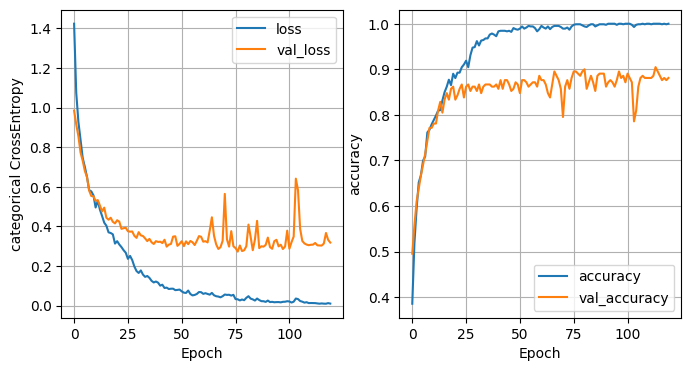

In [46]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('categorical CrossEntropy')
    ax1.legend() 
    ax1.grid(True)
    
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

plot_history(history)

In [47]:
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        90
           1       0.88      0.97      0.93        77
           2       0.94      0.89      0.91        96

    accuracy                           0.92       263
   macro avg       0.92      0.92      0.92       263
weighted avg       0.92      0.92      0.92       263



In [28]:
base = DenseNet121(weights=None, include_top=False, input_shape=(224,224,3))

# Load excluding the final layer (assuming 'dense' is the layer name)
base.load_weights("/kaggle/input/chexnet-keras-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5", by_name=True, skip_mismatch=True)             

In [26]:
base.trainable = True

set_trainable = False

for layer in base.layers:
    if layer.name in ['conv5_block15_2_conv','conv5_block15_1_conv','conv5_block16_2_conv','conv5_block16_1_conv']:
        layer.trainable = True
    else:
        layer.trainable = False
                

In [52]:
base.trainable = False
x = base.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base.input, outputs=predictions)

In [ ]:
#learning_rate = 0.01
#optimizer = Adam(learning_rate=learning_rate)
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train_encoded ,validation_data=(x_val,y_val_encoded), epochs=120, batch_size=64)

Epoch 1/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6338 - loss: 0.8400 - val_accuracy: 0.7000 - val_loss: 0.7582
Epoch 2/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.6109 - loss: 0.8409 - val_accuracy: 0.6619 - val_loss: 0.7639
Epoch 3/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.6113 - loss: 0.7870 - val_accuracy: 0.6857 - val_loss: 0.7743
Epoch 4/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.6281 - loss: 0.8013 - val_accuracy: 0.6905 - val_loss: 0.7656
Epoch 5/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.6181 - loss: 0.8288 - val_accuracy: 0.6857 - val_loss: 0.7634
Epoch 6/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.6343 - loss: 0.7854 - val_accuracy: 0.6810 - val_loss: 0.7618
Epoch 7/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.6218 - loss: 0.8133 - val_accuracy: 0.6810 - val_loss: 0.7649
Epoch 8/120
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.6394 - loss: 0.8183 - val_accura

In [31]:
base.trainable = False
model = Sequential()

model.add(base) 

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train_encoded ,validation_data=(x_val,y_val_encoded), epochs=70, batch_size=64)

Epoch 1/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.4515 - loss: 1.8403 - val_accuracy: 0.4083 - val_loss: 2.0694
Epoch 2/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5741 - loss: 1.4317 - val_accuracy: 0.4083 - val_loss: 1.8226
Epoch 3/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.6052 - loss: 1.2357 - val_accuracy: 0.4083 - val_loss: 1.5428
Epoch 4/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.6925 - loss: 1.0978 - val_accuracy: 0.5550 - val_loss: 1.5778
Epoch 5/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.6795 - loss: 1.0384 - val_accuracy: 0.4954 - val_loss: 1.5629
Epoch 6/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.7546 - loss: 0.8995 - val_accuracy: 0.5229 - val_loss: 1.4576
Epoch 7/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.7220 - loss: 0.9101 - val_accuracy: 0.3624 - val_loss: 1.5011
Epoch 8/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.7509 - loss: 0.8021 - val_accuracy: 0.55